# Set up

### Imports

To run this code you need a google account, and to follow the link below and create a shortcut to the folder.

https://drive.google.com/drive/folders/1YHmpr-a8FPFA3dOKW2fj4No_QOiY9AjM

The code snippet below allow for accessing this folder

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Write the path to the folder shortcut with the feature files

In [2]:
%cd gdrive/MyDrive/Experiments-feature-files

/content/gdrive/.shortcut-targets-by-id/1YHmpr-a8FPFA3dOKW2fj4No_QOiY9AjM/Experiments-feature-files


Test that everything worked correct by running the cell below and make sure you see these three files: 

Anomaly_Detection_train_test_features \\
Gas_Leak_E4_train_test_features \\
Gas_Leak_E1-E2-E3_train_test_features \\

In [3]:
!ls

Anomaly_Detection_train_test_features  Gas_Leak_E4_train_test_features
Gas_Leak_E1-E2-E3_train_test_features


In [4]:
import librosa
import matplotlib.pyplot as plt    
import numpy as np
import pandas as pd 
import seaborn as sns

#import librosa.display
#import matplotlib   
#import IPython.display as ipd
#from scipy.io import wavfile

from scipy import signal
from scipy.stats import norm, kurtosis
from scipy.signal import welch
from scipy.integrate import simps

#import scipy 

import operator #Used to sort 
import glob #
import json
from datetime import datetime

import statistics

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb


from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Functions

## Helper functions 

In [5]:
def preprocesses(X,T,normalize=True):
  if normalize:
    scaler = MinMaxScaler()
    scaler = scaler.fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X))
    X_scaled.columns = X.columns
    T_scaled = pd.DataFrame(scaler.transform(T))
    T_scaled.columns = T.columns

  return X_scaled, T_scaled 


In [11]:
def get_data_labels(df_train_features, df_test_features, drop_features=None):

  df_train_features_drop = df_train_features.drop(columns=['Unnamed: 0','feature_index', 'index','samples','sr','path','leak_type','knob_rotations','environment','recording','mic'],errors='ignore')
  df_test_features_drop = df_test_features.drop(columns=['Unnamed: 0','feature_index','index','samples','sr','path','leak_type','knob_rotations','environment','recording','mic'],errors='ignore')


  y = df_train_features_drop['leak_present'].values
  X = df_train_features_drop.drop(columns=['leak_present'])
  if drop_features: 
    X = X.drop(columns=drop_features)

  gt = df_test_features_drop['leak_present'].values
  T = df_test_features_drop.drop(columns=['leak_present'])
  if drop_features: 
    T = T.drop(columns=drop_features)



  return X,y,T,gt


# Run code

In [12]:
def untrained_ml_models():
    dt_1 = DecisionTreeClassifier(random_state=0, max_depth=1)
    dt = DecisionTreeClassifier(random_state=0)
    rf = RandomForestClassifier(random_state=0)
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", random_state=0)
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",  random_state=0)


    models = {
        "dt" : dt, 
        #"dt_1" : dt_1,
        "rf" : rf,
        "ada": ada,
        "xgb" : xgb_model,
    }

    return models

In [13]:
#USED FOR E1-E3
df_train_features_E1toE3 = pd.read_csv("Gas_Leak_E1-E2-E3_train_test_features")
#df_train_features_E1toE3 = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/E1E2")
df_train_features_E1toE3 = df_train_features_E1toE3.rename(columns={'rp_bin: 0': 'p_bin: 0-10kHz', 'rp_bin: 1': 'p_bin: 10-20kHz','rp_bin: 2': 'p_bin: 20-24kHz',})
df_train_features_E1toE3.sample(5)

,Unnamed: 0,index,feature_index,spec_centroid,spec_bandwidth,spec_flatness,zcr,rmse,cont_bin: 0,cont_bin: 1,...,p_bin: 20-24kHz,path,leak_type,environment,recording,mic,knob_rotations,leak_present,samples,sr
7781,7781,7781,2956.0,9008.170608,8350.852044,0.082899,0.249167,0.103327,23.192186,19.343431,...,-2.287918,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventlow,work_low,3,1,7.5n,1,[ 0.0000000e+00 -6.0212612e-04 8.6903572e-05 ...,48000
13677,13677,13677,5186.0,4430.270990,5631.625840,0.017174,0.056225,0.401163,21.696899,20.337301,...,-6.783844,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,tubeleak,work,3,1,8.0n,1,[ 0. 0.00225961 0.00509715 ... -0.00...,48000
7269,7269,7269,2753.0,2577.131178,2746.577136,0.000318,0.065579,0.091342,27.088674,20.367638,...,-13.467895,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventlow,hydr,3,1,4.5n,0,[0.0000000e+00 5.8770180e-05 7.1883202e-05 ......,48000
7465,7465,7465,2840.0,2682.978514,3155.196640,0.000690,0.061908,0.086455,29.817134,18.800866,...,-14.024424,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventlow,hydr,2,1,0.0n,0,[ 0. -0.00073397 -0.00145352 ... -0.00...,48000
2085,2085,2085,783.0,2466.607899,3259.539723,0.001007,0.039308,0.228338,25.271573,19.497736,...,-12.238342,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,work,3,1,3.0n,0,[ 0. -0.00117481 -0.00269747 ... 0.00...,48000


In [14]:
#USED FOR E4
df_train_features_E4 = pd.read_csv("Gas_Leak_E4_train_test_features") #Used for E4
#df_train_features_E4 = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/features_E4") #Used for E4
df_train_features_E4 = df_train_features_E4.rename(columns={'rp_bin: 0': 'p_bin: 0-10kHz', 'rp_bin: 1': 'p_bin: 10-20kHz','rp_bin: 2': 'p_bin: 20-24kHz',})
df_train_features_E4.sample(5)

,Unnamed: 0,index,feature_index,spec_centroid,spec_bandwidth,spec_flatness,zcr,rmse,cont_bin: 0,cont_bin: 1,...,p_bin: 20-24kHz,path,leak_type,environment,recording,mic,knob_rotations,leak_present,samples,sr
9707,9707,9707,5273.0,2770.511605,3166.413381,0.001297,0.062850,0.000847,24.144770,18.234404,...,-12.351348,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,tubeleak,hydr,2,2,0.0n,0,[ 0.0000000e+00 9.5367432e-07 1.7881393e-06 ...,48000
581,581,581,80.0,2898.455117,3807.881710,0.001465,0.057083,0.072914,25.410767,22.012808,...,-9.811976,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,hydr,1,2,6.0n,1,[ 0. -0.00026071 -0.00036991 ... -0.00...,48000
4442,4442,4442,905.0,2313.213856,3180.792342,0.001471,0.046929,0.056021,24.561490,19.962743,...,-11.318761,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,work,1,2,1.0n,0,[ 0.0000000e+00 -1.5497208e-05 -3.9935112e-05 ...,48000
5841,5841,5841,1090.0,1696.218767,2558.300770,0.000293,0.031879,0.014664,29.311934,21.666603,...,-13.509809,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,ventleak,work,2,3,4.5n,0,[ 0.0000000e+00 -4.4345856e-05 -9.5605850e-05 ...,48000
8676,8676,8676,5152.0,1908.606692,2684.455781,0.000410,0.038762,0.131019,28.397467,20.444746,...,-13.406991,/content/gdrive/MyDrive/Masteroppgave/IDMT_dat...,tubeleak,work,3,3,0.0n,0,[ 0. 0.00011814 0.00019443 ... -0.00...,48000


### Feature correlation

Text(0.5, 1.0, 'All Leaks - All Environemnts')

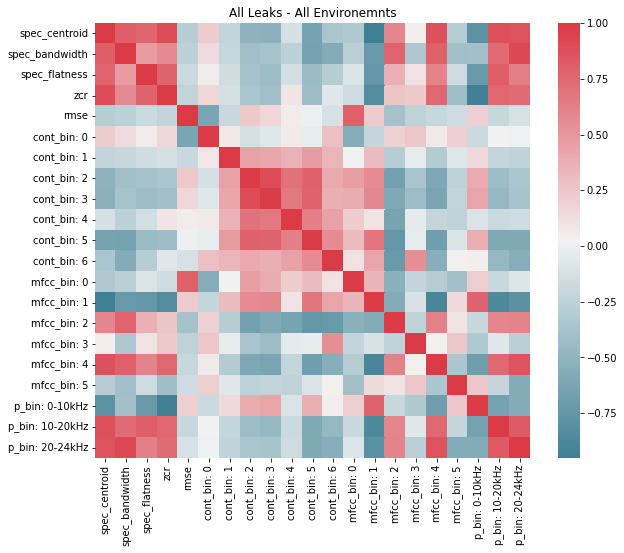

In [15]:
def plot_corr_matrix(df_features):
  # run correlation matrix and plot
  f, ax = plt.subplots(figsize=(10, 8))
  corr = df_features.corr()
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
              cmap=sns.diverging_palette(220, 10, as_cmap=True),
              square=True, ax=ax)

df_corr_feat_test = df_train_features_E1toE3.drop(columns={'Unnamed: 0', 'index', 'feature_index', 'recording', 'mic', 'sr', 'leak_present'})
plot_corr_matrix(df_corr_feat_test)
plt.title("All Leaks - All Environemnts")


## Testing


### E1 - all data from microphone 1

#### Getting E1 Accuracy

In [16]:
X = df_train_features_E1toE3 
y = X.leak_present.values


cv = StratifiedGroupKFold(n_splits=3)
env_groups = X.recording.values

models = untrained_ml_models()

all_results_E1 = {}

features_top5 = ['spec_bandwidth','spec_flatness', 'mfcc_bin: 5', 'zcr', 'p_bin: 20-24kHz']
features_top1 = ['p_bin: 20-24kHz']
all_features = []
sub_features = all_features #Selecting one of the options above

confusion=False

for model in models : 
  results = {}

  for train_idxs, test_idxs in cv.split(X,y,env_groups):
    #print("TRAIN:" + str(np.unique(env_groups[train_idxs])) + ", " + str(len(env_groups[train_idxs])))
    #print("TEST:" + str(np.unique(env_groups[test_idxs])) + ", " + str(len(env_groups[test_idxs])))

    X_test_info = X.iloc[test_idxs]
    
    X_train, y_train, X_test, y_test = get_data_labels(X.iloc[train_idxs], X.iloc[test_idxs])

    if sub_features:
      X_train = X_train[sub_features] #Using only the features decided on above
      X_test = X_test[sub_features]

    #Fitting and predicting models 
    models[model].fit(X_train,y_train)
    score = models[model].score(X_test , y_test)
    preds = models[model].predict(X_test)

    #Concatenating all the features with file information to the predictions 
    pred_col = pd.DataFrame(preds)
    pred_col.columns = ["preds"]
    pred_col.reset_index(drop=True, inplace=True)
    X_test_info.reset_index(drop=True, inplace=True)
    X_test_info_preds = pd.concat([X_test_info, pred_col["preds"]], axis=1)
    x_test_preds = X_test_info_preds

    if confusion and model=="rf":
      fig, ax = plt.subplots(figsize=(10,10))
      plt.title(model + " confusion matrix")
      disp = ConfusionMatrixDisplay.from_estimator(
          models["rf"],
          X_test,
          y_test,
          display_labels=[0,1],
          cmap=plt.cm.Blues,
          normalize="true",
          ax=ax) 
      plt.show()

    #Iterating over leaks and environments to see specific accuracy and scores 
    for leak in x_test_preds.leak_type.unique():
      for env in x_test_preds.environment.unique():
        preds = x_test_preds.loc[(x_test_preds.leak_type == leak) & (x_test_preds.environment == env)]["preds"]
        y_test = x_test_preds.loc[(x_test_preds.leak_type == leak) & (x_test_preds.environment == env)]["leak_present"]
        
        if len(preds) != 0:
          f1 = f1_score(preds, y_test)
          acc = accuracy_score(preds, y_test)
          metric = acc #Selecting what metric to use
        else: 
          metric = 0 
        #Storing the result of each fold in a list to take average of later 
        key = str(leak + "-" + env)
        if key in results:
          results[key].append(metric)
        else:
          results[key] = [metric]
  
  #Averaging all the results for each fold 
  average_results = {}
  for key, vals in results.items():
    if 0 in vals:
      vals.remove(0)
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals), "*"]
    else: 
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals)]

  #Storing the results for each model
  all_results_E1[model] = average_results

#Printing results
all_results_E1

{'ada': {'tubeleak-hydr': [89.41176470588235, 0.48029210642807696],
  'tubeleak-hydr_low': [93.20976911474649, 0.46548476741468114],
  'tubeleak-lab': [98.12503082939585, 1.8122495651290507],
  'tubeleak-work': [94.86928795186712, 3.25122844426799],
  'tubeleak-work_low': [95.81425931842568, 1.201856889973714],
  'ventleak-hydr': [93.60582115858578, 0.7733677585597134],
  'ventleak-hydr_low': [96.1306765523633, 0.7254414902901619],
  'ventleak-lab': [100.0, 0.0],
  'ventleak-work': [98.53961237674261, 1.097852635516311],
  'ventleak-work_low': [98.22485207100591, 1.7751479289940808, '*'],
  'ventlow-hydr': [93.06251423446516, 2.276933305692037],
  'ventlow-hydr_low': [93.72386180020911, 0.5028070883517519],
  'ventlow-lab': [97.64239028944912, 2.5393134927119365],
  'ventlow-work': [95.45174282730842, 2.4969923781578465],
  'ventlow-work_low': [93.8699717026986, 0.20501112779792108]},
 'dt': {'tubeleak-hydr': [88.33333333333333, 0.9091782838721277],
  'tubeleak-hydr_low': [91.736280310

#### Plotting Average Feature Importance for E1 Random Forest model

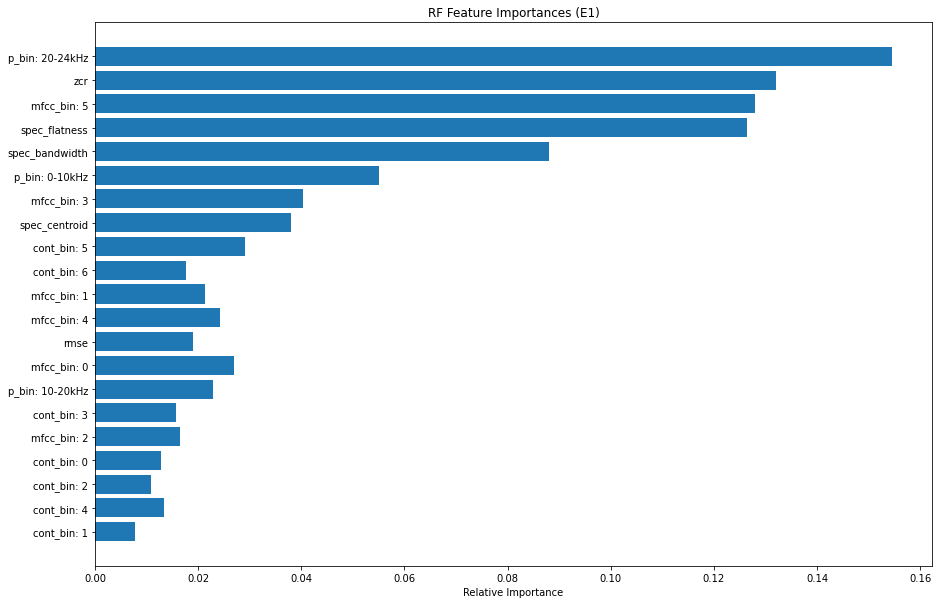

In [17]:

X = df_train_features_E1toE3 
y = X.leak_present.values

cv = StratifiedGroupKFold(n_splits=3)
env_groups = X.recording.values

models = untrained_ml_models()

plt.figure(figsize=(15,10)) 
plt.title("RF" + ' Feature Importances')
plt.xlabel('Relative Importance')



indices = []
all_fi = []
for train_idxs, test_idxs in cv.split(X,y,env_groups):
  X_train, y_train, X_test, y_test = get_data_labels(X.iloc[train_idxs], X.iloc[test_idxs])

  models["rf"].fit(X_train,y_train)
  
  fi_features = X_train.columns
  tree_feature_importances = models["rf"].feature_importances_
  plt.close()
  
  if len(indices) == 0: 
    indices = np.argsort(tree_feature_importances)

  all_fi.append(np.array(tree_feature_importances))

mean_fi = (all_fi[0] + all_fi[2] + all_fi[1]) /3 

plt.figure(figsize=(15,10)) 
plt.title("RF" + ' Feature Importances (E1)')
plt.xlabel('Relative Importance')
plt.barh(range(len(indices)), mean_fi[indices], align='center')
plt.yticks(range(len(indices)), [fi_features[i] for i in indices])
plt.show()

### E2 - different envs

#### Getting E2 accuracy

In [18]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score

X = df_train_features_E1toE3
y = X.leak_present.values

cv = StratifiedGroupKFold(n_splits=3)
env_groups = X.recording.values

models = untrained_ml_models()

confusion = False
do_tree = False

features_top4 =['spec_flatness', 'mfcc_bin: 5', 'zcr', 'p_bin: 20-24kHz']
features_top1 = ['p_bin: 20-24kHz']
all_features = []
sub_features = all_features #Selecting one of the options above


all_results_E2 = {}
for model in models : 
  results = {}
  for train_idxs, test_idxs in cv.split(X,y,env_groups):

    X_train_XXX = X.iloc[train_idxs].loc[X['environment'].isin(["hydr", "hydr_low"])]
    X_test_XXX = X.iloc[test_idxs].loc[X['environment'].isin(["work","work_low"])]
        
    X_test_info = X_test_XXX
    X_train, y_train, X_test, y_test = get_data_labels(X_train_XXX, X_test_XXX)

    if sub_features: 
      X_train = X_train[sub_features]
      X_test = X_test[sub_features]

    models[model].fit(X_train,y_train)
    score = models[model].score(X_test , y_test)
    preds = models[model].predict(X_test)

    #train_preds = models[model].predict(X_train)
    #print(model + ": train score: " + str(f1_score(train_preds, y_train)))
    #print(model + ": pred true: " + str(sum(preds)/len(preds)))
    #print(model + ": recall: " + str(recall_score(y_test, preds)))

    pred_col = pd.DataFrame(preds)
    pred_col.columns = ["preds"]
    pred_col.reset_index(drop=True, inplace=True)
    X_test_info.reset_index(drop=True, inplace=True)
    X_test_info_preds = pd.concat([X_test_info, pred_col["preds"]], axis=1)
    aaa = X_test_info_preds

    
    if model == "dt_1" and do_tree: 
      #Plot three representation
      fn = X_train.columns.values
      cn=['leak', 'no_leak']  
      print(tree.export_text(models[model],decimals=4))
      fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=150)
      tree.plot_tree(models[model],
                    feature_names = fn, 
                    class_names=cn,
                    precision=4,
                    filled = True)
      #plt.title("Visual representation of decision tree")
      plt.show()


    #features = X_train.columns
    #tree_feature_importances = models[model].feature_importances_
    #indices = np.argsort(tree_feature_importances)

    if confusion: 
      fig, ax = plt.subplots(figsize=(10,10))
      plt.title(model + " confusion matrix")
      disp = ConfusionMatrixDisplay.from_estimator(
          models[model],
          X_test,
          y_test,
          display_labels=[0,1],
          cmap=plt.cm.Blues,
          normalize="true",
          ax=ax) 
      plt.show()
    
    for leak in aaa.leak_type.unique():
      for env in aaa.environment.unique():
        preds = aaa.loc[(aaa.leak_type == leak)]["preds"]
        y_test = aaa.loc[(aaa.leak_type == leak)]["leak_present"]
        

        if len(preds) != 0:
          f1 = f1_score(preds, y_test)
          acc = accuracy_score(preds, y_test)
          metric = acc #Selecting what metric to use

        else: 
          metric = 0 

        key = str(leak + "-" + env)
        if key in results:
          results[key].append(metric)
        else:
          results[key] = [metric]
    
  average_results = {}
  for key, vals in results.items():
    if (0.0 in vals) or (0 in vals):
      vals.remove(0)
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals), "*"]
    else: 
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals)]

  all_results_E2[model] = average_results


all_results_E2

{'ada': {'tubeleak-work': [86.75305175998153, 2.51894372627464],
  'tubeleak-work_low': [86.75305175998153, 2.51894372627464],
  'ventleak-work': [91.29625716703465, 4.109523148419067],
  'ventleak-work_low': [91.29625716703465, 4.109523148419067],
  'ventlow-work': [89.3575275364672, 6.660146377769383],
  'ventlow-work_low': [89.3575275364672, 6.660146377769383]},
 'dt': {'tubeleak-work': [60.86550933740828, 2.196201908264973],
  'tubeleak-work_low': [60.86550933740828, 2.196201908264973],
  'ventleak-work': [73.1897918901713, 7.681683954186908],
  'ventleak-work_low': [73.1897918901713, 7.681683954186908],
  'ventlow-work': [65.11145390742695, 7.087796767397557],
  'ventlow-work_low': [65.11145390742695, 7.087796767397557]},
 'rf': {'tubeleak-work': [85.05733340440781, 3.340061599610944],
  'tubeleak-work_low': [85.05733340440781, 3.340061599610944],
  'ventleak-work': [89.84484056867407, 3.509021654739661],
  'ventleak-work_low': [89.84484056867407, 3.509021654739661],
  'ventlow-wo

### E3 - different leaks 

In [19]:
#Selecting which mic to test with of 1 and 4 
X = df_train_features_E1toE3
y = X.leak_present.values


cv = StratifiedGroupKFold(n_splits=3)
env_groups = X.recording.values

models = untrained_ml_models()

confusion = False
do_tree = False
feature_importance = False


features_top4 =['spec_flatness', 'mfcc_bin: 5', 'zcr', 'p_bin: 20-24kHz']
features_top1 = ['p_bin: 20-24kHz']
all_features = []
sub_features = all_features #Selecting one of the options above


all_results_E3 = {}
for model in models : 
  results = {}
  for train_idxs, test_idxs in cv.split(X,y,env_groups):

    X_train_XXX = X.iloc[train_idxs].loc[X['leak_type'].isin(["tubeleak"])]
    X_test_XXX = X.iloc[test_idxs].loc[X['leak_type'].isin(["ventleak"])]
        
    X_test_info = X_test_XXX
    X_train, y_train, X_test, y_test = get_data_labels(X_train_XXX, X_test_XXX)

    if sub_features: 
      X_train = X_train[sub_features]
      X_test = X_test[sub_features]      

    models[model].fit(X_train,y_train)
    score = models[model].score(X_test , y_test)
    preds = models[model].predict(X_test)

    train_preds = models[model].predict(X_train)
    print(model + ": train score: " + str(f1_score(train_preds, y_train)))
    print(model + ": test score: " + str(f1_score(preds, y_test)))
    #print(model + ": pred true: " + str(sum(preds)/len(preds)))
    #print(model + ": recall: " + str(recall_score(y_test, preds)))


    pred_col = pd.DataFrame(preds)
    pred_col.columns = ["preds"]
    pred_col.reset_index(drop=True, inplace=True)
    X_test_info.reset_index(drop=True, inplace=True)
    X_test_info_preds = pd.concat([X_test_info, pred_col["preds"]], axis=1)
    aaa = X_test_info_preds

    if model == "dt_1" and do_tree: 
      #Plot three representation
      fn = X_train.columns.values
      cn=['leak', 'no_leak']  
      print(tree.export_text(models[model],decimals=4))
      fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=150)
      tree.plot_tree(models[model],
                    feature_names = fn, 
                    class_names=cn,
                    precision=4,
                    filled = True)
      plt.title("Visual representation of decision tree")
      plt.show()


    features = X_train.columns
    tree_feature_importances = models[model].feature_importances_
    indices = np.argsort(tree_feature_importances)

    if confusion: 
      fig, ax = plt.subplots(figsize=(10,10))
      plt.title(model + " confusion matrix")
      disp = ConfusionMatrixDisplay.from_estimator(
          models[model],
          X_test,
          y_test,
          display_labels=[0,1],
          cmap=plt.cm.Blues,
          normalize="true",
          ax=ax) 
      plt.show()
    
    for leak in aaa.leak_type.unique():
        for env in aaa.environment.unique():
          preds = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["preds"]
          y_test = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["leak_present"]
      
          if len(preds) != 0:
            f1 = f1_score(preds, y_test)
            acc = accuracy_score(preds, y_test)
            metric = f1 #Selecting what metric to use
          else: 
            metric = 0 

          key = str(leak + "-" + env)
          if key in results:
            results[key].append(metric)
          else:
            results[key] = [metric]
      

  if feature_importance and model=="rf": 
    plt.figure(figsize=(15,10)) 
    plt.title(model + ' Feature Importances')
    plt.xlabel('Relative Importance')
    plt.barh(range(len(indices)), tree_feature_importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.show()
  

  average_results = {}
  for key, vals in results.items():
    if (0.0 in vals) or (0 in vals):
      print(vals)
      vals.remove(0)
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals), "*"]
    else: 
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals)]

  all_results_E3[model] = average_results



all_results_E3

dt: train score: 1.0
dt: test score: 0.9568764568764568
dt: train score: 1.0
dt: test score: 0.9407023603914796
dt: train score: 1.0
dt: test score: 0.9439528023598821
rf: train score: 1.0
rf: test score: 0.983132530120482
rf: train score: 1.0
rf: test score: 0.9820143884892086
rf: train score: 1.0
rf: test score: 0.9741248097412482
ada: train score: 0.9517157607045248
ada: test score: 0.9790794979079498
ada: train score: 0.9522370012091899
ada: test score: 0.958259847148736
ada: train score: 0.9580693815987934
ada: test score: 0.9640179910044977
xgb: train score: 0.9786466165413534
xgb: test score: 0.9801801801801802
xgb: train score: 0.9798253538090936
xgb: test score: 0.9803220035778175
xgb: train score: 0.979285499849895
xgb: test score: 0.9750566893424036


{'ada': {'ventleak-hydr': [93.81726947044866, 0.2915004200114599],
  'ventleak-hydr_low': [95.10295836705332, 1.7828679205530762],
  'ventleak-lab': [99.90108803165182, 0.13988264711900011],
  'ventleak-work': [97.60669685741732, 1.7949815535891356],
  'ventleak-work_low': [97.44021129563298, 2.259488404066717]},
 'dt': {'ventleak-hydr': [92.50382785245961, 1.9053071167797788],
  'ventleak-hydr_low': [92.76954298241695, 2.082121925184281],
  'ventleak-lab': [99.02474264041899, 0.8356030177376871],
  'ventleak-work': [94.98723965297447, 2.539582829267663],
  'ventleak-work_low': [94.37316715542522, 0.05498533724340726]},
 'rf': {'ventleak-hydr': [95.323071892394, 1.598219697582968],
  'ventleak-hydr_low': [96.84609931134386, 0.14927587253434327],
  'ventleak-lab': [100.0, 0.0],
  'ventleak-work': [99.12076101621275, 0.6346406039590649],
  'ventleak-work_low': [98.94894894894894, 1.0510510510510551]},
 'xgb': {'ventleak-hydr': [95.19549184214152, 1.7603980798812917],
  'ventleak-hydr_low

### E4 - different microphoness

In [20]:
X = df_train_features_E4
y = df_train_features_E4.leak_present.values 

cv = StratifiedGroupKFold(n_splits=3)
env_groups = X.recording.values

models = untrained_ml_models()

confusion = False

mics = X.mic.unique()
r = len(mics) - 1
mic_combos = combinations(mics, r)

all_results_E4 = {}

for combo in mic_combos:
  combo_results_E4 = {}
  #average_results = {}
  train = list(combo)
  test = list(set(mics) - set(train))
  #print(" ")
  #print("Mic : " + str(test[0]))
  for model in models: 
    #print(model)
    results = {}
    for train_idxs, test_idxs in cv.split(X,y,env_groups):
        #print("TRAIN:" + str(np.unique(env_groups[train_idxs])) + ", " + str(len(env_groups[train_idxs])))
        #print("TEST:" + str(np.unique(env_groups[test_idxs])) + ", " + str(len(env_groups[test_idxs])))
        X_test_info = X.iloc[test_idxs]
        X_train_XXX = X.iloc[train_idxs].loc[X['mic'].isin(train)]
        X_test_XXX = X.iloc[test_idxs].loc[X['mic'].isin(test)]
        X_test_info = X_test_XXX
        X_train, y_train, X_test, y_test = get_data_labels(X_train_XXX, X_test_XXX)


        X_train = X_train[['p_bin: 20-24kHz']]
        X_test = X_test[['p_bin: 20-24kHz']]   

        models[model].fit(X_train,y_train)
        score = models[model].score(X_test,y_test)
        preds = models[model].predict(X_test)

        print("pred true: " + str(sum(preds)/len(preds)))
        pred_col = pd.DataFrame(preds)
        pred_col.columns = ["preds"]
        pred_col.reset_index(drop=True, inplace=True)
        X_test_info.reset_index(drop=True, inplace=True)
        X_test_info_preds = pd.concat([X_test_info, pred_col["preds"]], axis=1)
        aaa = X_test_info_preds

        if confusion: 
          fig, ax = plt.subplots(figsize=(10,10))
          plt.title(model + " confusion matrix")
          disp = ConfusionMatrixDisplay.from_estimator(
              models[model],
              X_test,
              y_test,
              display_labels=[0,1],
              cmap=plt.cm.Blues,
              normalize="true",
              ax=ax) 
          plt.show()

        for leak in aaa.leak_type.unique():
          for env in aaa.environment.unique():
            preds = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["preds"]
            y_test = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["leak_present"]
            #print(recall_score(y_test, preds, average='macro'))
            try: 
              if len(preds) != 0:
                f1 = f1_score(preds, y_test)
                acc = accuracy_score(preds, y_test)
                metric = f1 #Selecting what metric to use
              else: 
                metric = 0 
            except:
              metric =0
            key = str(leak) + "-" + env + "-" + str(test)
            if key in results:
              results[key].append(metric)
            else:
              results[key] = [metric]
      
        #print(model)
        #print(results)


        average_results = {}
        for key, vals in results.items():
          if 0 in vals:
            #print(vals)
            vals.remove(0)
            try:
              average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals), "*"]
            except: 
              average_results[key] = [0,0,"**"]
          else: 
            average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals)]

    combo_results_E4[model] = average_results
  all_results_E4[str(test[0])] = combo_results_E4 

all_results_E4


pred true: 0.4528023598820059
pred true: 0.539647577092511
pred true: 0.3645066273932253
pred true: 0.4528023598820059
pred true: 0.539647577092511
pred true: 0.3645066273932253
pred true: 0.28761061946902655
pred true: 0.2936857562408223
pred true: 0.21502209131075112
pred true: 0.38495575221238937
pred true: 0.5330396475770925
pred true: 0.26730486008836524
pred true: 0.633480825958702
pred true: 0.6629955947136564
pred true: 0.5891016200294551
pred true: 0.633480825958702
pred true: 0.6622613803230544
pred true: 0.5891016200294551
pred true: 0.5936578171091446
pred true: 0.630690161527166
pred true: 0.5139911634756995
pred true: 0.5936578171091446
pred true: 0.631424375917768
pred true: 0.5942562592047128
pred true: 0.45132743362831856
pred true: 0.5367107195301027
pred true: 0.42415316642120765
pred true: 0.45132743362831856
pred true: 0.5367107195301027
pred true: 0.42415316642120765
pred true: 0.35914454277286134
pred true: 0.40602055800293685
pred true: 0.35051546391752575
pred 

{'1': {'ada': {'tubeleak-hydr-[1]': [77.31663140769611, 0.6370281874669961],
   'tubeleak-work-[1]': [93.23998748253545, 2.2270802634724864],
   'ventleak-hydr-[1]': [80.2534640815574, 3.952947852249547],
   'ventleak-work-[1]': [97.57244840264464, 0.2934154088342033]},
  'dt': {'tubeleak-hydr-[1]': [77.89738831352332, 0.2960188254510427],
   'tubeleak-work-[1]': [84.55129855197812, 1.4191146347754473],
   'ventleak-hydr-[1]': [81.79482803138717, 2.062187405745317],
   'ventleak-work-[1]': [88.83605951047059, 1.7973429630317]},
  'rf': {'tubeleak-hydr-[1]': [77.89738831352332, 0.2960188254510427],
   'tubeleak-work-[1]': [84.62147761622855, 1.3302867431340182],
   'ventleak-hydr-[1]': [81.79482803138717, 2.062187405745317],
   'ventleak-work-[1]': [88.83605951047059, 1.7973429630317]},
  'xgb': {'tubeleak-hydr-[1]': [77.0461724266072, 0.2569759659220328],
   'tubeleak-work-[1]': [93.74633206642152, 1.3649926070225704],
   'ventleak-hydr-[1]': [77.20780478589809, 0.6479569950459503],
  

### Reformating results for experiments

#### E1

In [21]:
env_order = ["lab", "work_low", "work", "hydr_low", "hydr"]
leak_order = ["ventleak", "ventlow", "tubeleak"]
models = ["dt", "rf", "ada", "xgb"]

data = all_results_E1


verbose = False
for model in models: 
  print(model)
  for env in env_order: 
    sum = []
    for leak in leak_order: 
      #for key in data: 
        for info in data[model]: 
          a = info.split("-")[0]
          b = info.split("-")[-1]
          if a == leak and b == env:
            if len(data[model][info]) == 3 and verbose: 
              print("* below?")
            else:
              acc = data[model][info][0]
              res = data[model][info][1]
              acc_short = float(str(acc)[:5]) 
              res_short = float(str(res)[:4]) 
              sum.append(acc)
            #  #print("alert below") 
              
        if verbose: 
          print(leak + ", " + env + ": " + str(acc_short) + "," + str(res_short))
        else: 
          print(str(acc_short) + "," + str(res_short))
    if verbose: 
      print("Average " + env + ": " + str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:5])
    else: 
      print(str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:4])

  print("_________________")

dt
98.57,1.52
95.75,3.02
97.04,1.68
97.12,1.15
95.25,0.6
90.7,3.26
93.92,1.7
93.29,1.90
95.69,1.34
93.38,1.98
92.7,1.39
93.92,1.27
96.72,1.28
91.83,0.98
91.73,1.44
93.43,2.32
93.31,0.56
89.46,1.33
88.33,0.9
90.37,2.13
_________________
rf
99.86,0.18
97.44,2.46
97.73,2.37
98.34,1.08
98.66,1.33
94.06,0.29
97.01,1.5
96.58,1.90
99.12,0.47
95.84,2.52
95.85,2.72
96.94,1.54
98.71,0.77
94.72,1.1
96.06,0.76
96.49,1.65
95.69,1.78
94.73,1.4
92.84,1.32
94.42,1.18
_________________
ada
100.0,0.0
97.64,2.53
98.12,1.81
98.58,1.01
98.22,1.77
93.86,0.2
95.81,1.2
95.96,1.78
98.53,1.09
95.45,2.49
94.86,3.25
96.28,1.61
96.13,0.72
93.72,0.5
93.2,0.46
94.35,1.27
93.6,0.77
93.06,2.27
89.41,0.48
92.02,1.86
_________________
xgb
99.9,0.14
96.94,2.4
97.82,2.23
98.22,1.23
98.81,1.18
94.26,0.53
96.41,1.44
96.49,1.85
99.02,0.73
95.25,2.12
95.85,2.51
96.71,1.65
98.21,0.25
94.32,0.65
95.57,0.63
96.03,1.62
95.6,1.84
94.74,1.37
92.54,2.23
94.29,1.28
_________________


#### E2

In [22]:
data = all_results_E2
leak_order = ["ventleak", "ventlow", "tubeleak"]


verbose = False
for model in data.keys(): 
  print(model)
  sum = []
  for leak in leak_order: 
    #for key in data: 
      for info in data[model]: 
        a_leak = info.split("-")[0]
        b_env = info.split("-")[-1]
        if a_leak == leak:
          if len(data[model][info]) == 3 and verbose: 
            print("* below?")
          else:
            acc = data[model][info][0]
            res = data[model][info][1]
            acc_short = float(str(acc)[:5]) 
            res_short = float(str(res)[:4]) 
            sum.append(acc)
          #  #print("alert below") 
            
      if verbose: 
        print(leak + ", " + b_env + ": " + str(acc_short) + "," + str(res_short))
      else: 
        print(str(acc_short) + "," + str(res_short))
  if verbose: 
    print("Average " + b_env + ": " + str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:5])
  else: 
    print(str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:4])

  print("_________________")

dt
73.18,7.68
65.11,7.08
60.86,2.19
66.38,5.11
_________________
rf
89.84,3.5
85.45,5.96
85.05,3.34
86.78,2.16
_________________
ada
91.29,4.1
89.35,6.66
86.75,2.51
89.13,1.86
_________________
xgb
93.01,3.5
89.51,6.25
88.53,1.92
90.35,1.92
_________________


#### E3

In [23]:
env_order = ["lab", "work_low", "work", "hydr_low", "hydr"]
data = all_results_E3
test_leak = "tubeleak"

print("Results: E3")
print("___________")
verbose = False
for model in data.keys(): 
  print(model)
  sum = []
  for env in env_order: 
    #for key in data: 
      for info in data[model]: 
        a_leak = info.split("-")[0]
        b_env = info.split("-")[-1]
        if b_env == env:
          if len(data[model][info]) == 3 and verbose: 
            print("* below?")
          acc = data[model][info][0]
          res = data[model][info][1]
          acc_short = float(str(acc)[:5]) 
          res_short = float(str(res)[:4]) 
          sum.append(acc)
        #  #print("alert below") 
            
      if verbose: 
        print(leak + ", " + env + ": " + str(acc_short) + "," + str(res_short))
      else: 
        print(str(acc_short) + "," + str(res_short))
  if verbose: 
    print("Average " + env + ": " + str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:5])
  else: 
    print(str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:4])

  print("_________________")

Results: E3
___________
dt
99.02,0.83
94.37,0.05
94.98,2.53
92.76,2.08
92.5,1.9
94.73,2.34
_________________
rf
100.0,0.0
98.94,1.05
99.12,0.63
96.84,0.14
95.32,1.59
98.04,1.71
_________________
ada
99.9,0.13
97.44,2.25
97.6,1.79
95.1,1.78
93.81,0.29
96.77,2.11
_________________
xgb
99.9,0.13
98.8,1.19
98.65,0.97
97.04,0.14
95.19,1.76
97.91,1.63
_________________


#### E4

In [25]:
env_order = ["work", "hydr"]
leak_order = ["ventleak", "tubeleak"]

data = all_results_E4

print("Results: E4")
print("___________")
verbose = False
for mic_test in data.keys():
  print(mic_test)
  print("- - - -")
  for model in data[mic_test].keys(): 
    print(model)
    sum = []
    for env in env_order: 
      #sum = []
      for leak in leak_order: 
        #for key in data: 
          for info in data[mic_test][model]: 
            a = info.split("-")[0]
            b = info.split("-")[1]
            if a == leak and b == env:
              if len(data[mic_test][model][info]) == 3 and verbose: 
                print("* below?")
              else:
                acc = data[mic_test][model][info][0]
                res = data[mic_test][model][info][1]
                acc_short = float(str(acc)[:5]) 
                res_short = float(str(res)[:4]) 
                sum.append(acc)
                #print("alert below") 
          if verbose: 
            print(leak + ", " + env + ": " + str(acc_short) + "," + str(res_short))
          else: 
            print(str(acc_short) + "," + str(res_short))
    if verbose: 
      try: 
        print("Average mic: " + mic_test + ": " + str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:5])
      except: 
        print(0, "FIRST FLOOW")
    else: 
      try: 
        print(str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:4])
      except: 
        print(0, "SECOND FLOOR")

    print("_________________")

Results: E4
___________
2
- - - -
dt
84.94,2.08
64.5,7.33
80.81,3.16
39.9,5.96
67.54,17.6
_________________
rf
84.94,2.08
64.5,7.33
80.81,3.16
39.9,5.96
67.54,17.6
_________________
ada
94.96,3.38
58.83,24.7
84.32,1.4
0.0,0.0
59.53,36.7
_________________
xgb
88.6,2.72
65.02,8.73
84.57,5.02
33.19,14.3
67.84,21.9
_________________
1
- - - -
dt
88.83,1.79
84.55,1.41
81.79,2.06
77.89,0.29
83.26,3.98
_________________
rf
88.83,1.79
84.62,1.33
81.79,2.06
77.89,0.29
83.28,3.99
_________________
ada
97.57,0.29
93.23,2.22
80.25,3.95
77.31,0.63
87.09,8.51
_________________
xgb
97.79,0.26
93.74,1.36
77.2,0.64
77.04,0.25
86.44,9.43
_________________
3
- - - -
dt
89.78,1.78
82.01,2.89
90.71,0.85
66.4,7.32
82.22,9.74
_________________
rf
89.78,1.78
82.01,2.89
90.71,0.85
66.4,7.32
82.22,9.74
_________________
ada
97.18,2.06
87.86,3.79
92.39,1.05
54.34,11.3
82.94,16.8
_________________
xgb
96.43,1.1
88.06,3.56
93.63,0.61
60.31,10.4
84.61,14.3
_________________
